In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
c:\Users\nguye\Desktop\Crystal-Plasticity-Journal-Project\notebooks
Moving up to the parent directory
c:\Users\nguye\Desktop\Crystal-Plasticity-Journal-Project


In [2]:
###################################
# Preprocessing nonlinear loading #
###################################

def preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ):
    strainPathXprocess = strainPathX.copy()
    strainPathYprocess = strainPathY.copy()
    strainPathZprocess = strainPathZ.copy()
    turningIndices = turningStressPoints(trueStress)
    #print(turningIndices)
    #unloadingIndex = turningIndices[0]
    reloadingIndex = turningIndices[1]
    for i in range(reloadingIndex, trueStrain.size):
        strainPathXprocess[i] -= strainPathX[reloadingIndex]
        strainPathYprocess[i] -= strainPathY[reloadingIndex]
        strainPathZprocess[i] -= strainPathZ[reloadingIndex]
    strainReloading = (2/3 * (strainPathXprocess ** 2 + strainPathYprocess ** 2 + strainPathZprocess ** 2)) ** (1/2) + trueStrain[reloadingIndex]
    actualStrain = trueStrain.copy()
    for i in range(reloadingIndex, trueStrain.size):
        actualStrain[i] = strainReloading[i]
    return {"strain": actualStrain, "stress": trueStress}

def turningStressPoints(trueStress):
    differences = np.diff(trueStress)
    index = 1
    turningIndices = []
    while index < differences.size:
        if (differences[index - 1] <= 0 and differences[index] >= 0) or (differences[index - 1] >= 0 and differences[index] <= 0):
            turningIndices.append(index)
        index += 1
    return turningIndices

def preprocessDAMASKNonlinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))","1_ln(V)","5_ln(V)","9_ln(V)"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    strainPathX = df["1_ln(V)"].to_numpy().reshape(-1)
    strainPathY = df["5_ln(V)"].to_numpy().reshape(-1)
    strainPathZ = df["9_ln(V)"].to_numpy().reshape(-1)
    return preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ)

################################
# Preprocessing linear loading #
################################

def preprocessLinear(trueStrain, trueStress):
    # truePlasticStrain = trueStrain - trueElasticstrain = trueStrain - trueStress/Young's modulus
    Young = (trueStress[1] - trueStress[0]) / (trueStrain[1] - trueStrain[0])
    truePlasticStrain = trueStrain - trueStress / Young    
    return {"strain": truePlasticStrain, "stress": trueStress}

def preprocessDAMASKLinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    return preprocessLinear(trueStrain, trueStress)   

##############################
# Obtain the original curves #
##############################

def preprocessDAMASKTrue(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy()
    trueStress = df["Mises(Cauchy)"].to_numpy()
    return {"strain": trueStrain, "stress": trueStress}

In [12]:
initial_trueCurve_27 = preprocessDAMASKTrue(f'notebooks/RVE_1_40_D_tensionX.txt')
initial_processCurve_27 = preprocessDAMASKNonlinear(f'notebooks/RVE_1_40_D_tensionX.txt')

initial_processCurves = np.load(f'notebooks/PH/25-50/initial_processCurves.npy', allow_pickle=True)
initial_processCurves = initial_processCurves.tolist()

initial_trueCurves = np.load(f'notebooks/PH/25-50/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves = initial_trueCurves.tolist()

initial_processCurves["nonlinear_planestrain_TD"][(('a', 2.23812), ('h0', 1605.552776), ('tau0', 28.973487), ('tausat', 620.190095), ('self', 1.092547), ('coplanar', 0.228115), ('collinear', 21.623312), ('orthogonal', 0.067034), ('glissile', 0.991997), ('sessile', 0.286644))] = initial_processCurve_27
initial_trueCurves["nonlinear_planestrain_TD"][(('a', 2.23812), ('h0', 1605.552776), ('tau0', 28.973487), ('tausat', 620.190095), ('self', 1.092547), ('coplanar', 0.228115), ('collinear', 21.623312), ('orthogonal', 0.067034), ('glissile', 0.991997), ('sessile', 0.286644))] = initial_trueCurve_27


np.save(f'notebooks/PH/initial_processCurves.npy', initial_processCurves)

np.save(f'notebooks/PH/initial_trueCurves.npy',initial_trueCurves)


(('a', 4.030016), ('h0', 1919.209605), ('tau0', 184.370685), ('tausat', 664.667834), ('self', 1.453727), ('coplanar', 1.833917), ('collinear', 11.343172), ('orthogonal', 1.497749), ('glissile', 0.867434), ('sessile', 2.774888))
(('a', 4.030016), ('h0', 1919.209605), ('tau0', 184.370685), ('tausat', 664.667834), ('self', 1.453727), ('coplanar', 1.833917), ('collinear', 11.343172), ('orthogonal', 1.497749), ('glissile', 0.867434), ('sessile', 2.774888))


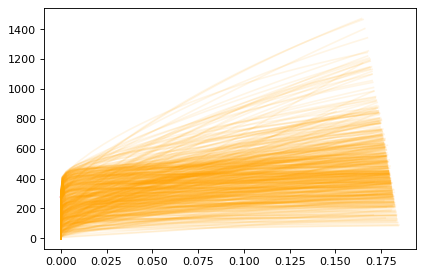

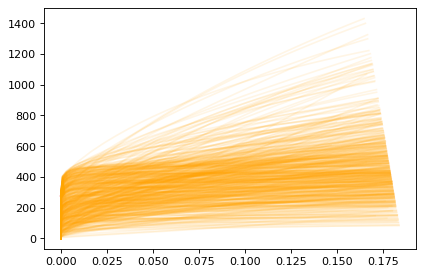

In [11]:
figure(figsize=(6, 4), dpi=80)
loading = "linear_uniaxial_RD"
initial_processCurves1 = np.load(f'notebooks/merging_linear/{loading}/1/initial_processCurves.npy', allow_pickle=True)
initial_processCurves1 = initial_processCurves1.tolist()
initial_trueCurves1 = np.load(f'notebooks/merging_linear/{loading}/1/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves1 = initial_trueCurves1.tolist()

initial_processCurves2 = np.load(f'notebooks/merging_linear/{loading}/2/initial_processCurves.npy', allow_pickle=True)
initial_processCurves2 = initial_processCurves2.tolist()
initial_trueCurves2 = np.load(f'notebooks/merging_linear/{loading}/2/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves2 = initial_trueCurves2.tolist()

initial_processCurves3 = np.load(f'notebooks/merging_linear/{loading}/3/initial_processCurves.npy', allow_pickle=True)
initial_processCurves3 = initial_processCurves3.tolist()
initial_trueCurves3 = np.load(f'notebooks/merging_linear/{loading}/3/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves3 = initial_trueCurves3.tolist()

initial_processCurves = {}
initial_processCurves.update(initial_processCurves1)
initial_processCurves.update(initial_processCurves2)
initial_processCurves.update(initial_processCurves3)

initial_trueCurves = {}
initial_trueCurves.update(initial_trueCurves1)
initial_trueCurves.update(initial_trueCurves2)
initial_trueCurves.update(initial_trueCurves3)

print(list(initial_processCurves)[0])
for curve in list(initial_processCurves.values()):
    plt.plot(curve["strain"], curve["stress"], alpha = 0.1, color = "orange")

np.save(f"results/RVE_1_40_D/PH/universal/{loading}/initial_processCurves.npy", initial_processCurves)
np.save(f"results/RVE_1_40_D/PH/universal/{loading}/initial_trueCurves.npy", initial_trueCurves)

figure(figsize=(6, 4), dpi=80)

loading = "linear_uniaxial_TD"
initial_processCurves1 = np.load(f'notebooks/merging_linear/{loading}/1/initial_processCurves.npy', allow_pickle=True)
initial_processCurves1 = initial_processCurves1.tolist()
initial_trueCurves1 = np.load(f'notebooks/merging_linear/{loading}/1/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves1 = initial_trueCurves1.tolist()

initial_processCurves2 = np.load(f'notebooks/merging_linear/{loading}/2/initial_processCurves.npy', allow_pickle=True)
initial_processCurves2 = initial_processCurves2.tolist()
initial_trueCurves2 = np.load(f'notebooks/merging_linear/{loading}/2/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves2 = initial_trueCurves2.tolist()

initial_processCurves3 = np.load(f'notebooks/merging_linear/{loading}/3/initial_processCurves.npy', allow_pickle=True)
initial_processCurves3 = initial_processCurves3.tolist()
initial_trueCurves3 = np.load(f'notebooks/merging_linear/{loading}/3/initial_trueCurves.npy', allow_pickle=True)
initial_trueCurves3 = initial_trueCurves3.tolist()

initial_processCurves = {}
initial_processCurves.update(initial_processCurves1)
initial_processCurves.update(initial_processCurves2)
initial_processCurves.update(initial_processCurves3)

initial_trueCurves = {}
initial_trueCurves.update(initial_trueCurves1)
initial_trueCurves.update(initial_trueCurves2)
initial_trueCurves.update(initial_trueCurves3)

print(list(initial_processCurves)[0])
for curve in list(initial_processCurves.values()):
    plt.plot(curve["strain"], curve["stress"], alpha = 0.1, color = "orange")

np.save(f"results/RVE_1_40_D/PH/universal/{loading}/initial_processCurves.npy", initial_processCurves)
np.save(f"results/RVE_1_40_D/PH/universal/{loading}/initial_trueCurves.npy", initial_trueCurves)

### Combine and plot PH universal initial simulations

True
True
True
True
True
True
500
101
500
500
500
500
500
500
500


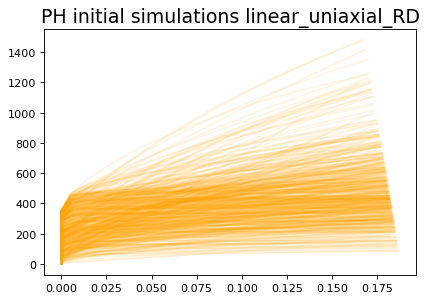

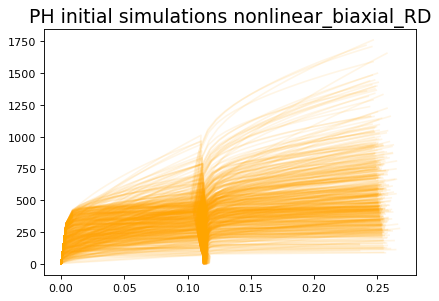

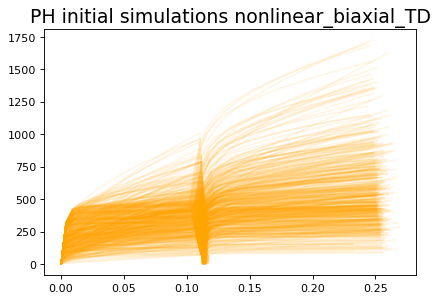

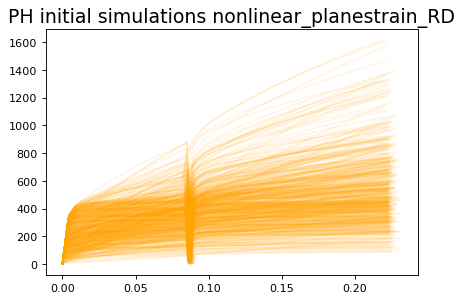

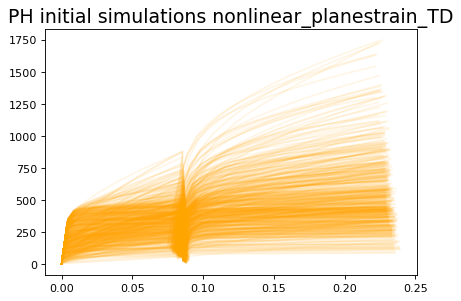

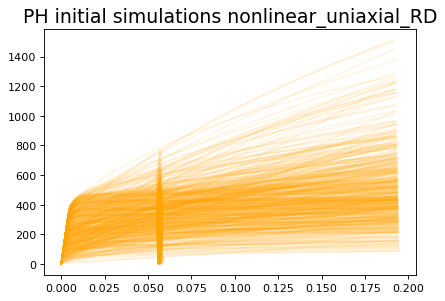

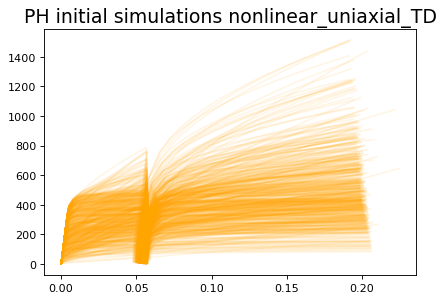

In [15]:
loadings = ["linear_uniaxial_RD", 
            "nonlinear_biaxial_RD", 
            "nonlinear_biaxial_TD",     
            "nonlinear_planestrain_RD",     
            "nonlinear_planestrain_TD",     
            "nonlinear_uniaxial_RD", 
            "nonlinear_uniaxial_TD"]

lower = 0
step = 25
combined_initial_processCurves = {}
combined_initial_trueCurves = {}
combined_initial_params = []
combined_nonconverging_params = []
for loading in loadings:
    combined_initial_processCurves[loading] = {}
    combined_initial_trueCurves[loading] = {}

while lower <= 475:
    upper = lower + step
    #print(f"{lower}-{upper}")
    initial_processCurves = np.load(f'notebooks/PH/{lower}-{upper}/initial_processCurves.npy', allow_pickle=True)
    initial_processCurves = initial_processCurves.tolist()
    initial_trueCurves = np.load(f'notebooks/PH/{lower}-{upper}/initial_trueCurves.npy', allow_pickle=True)
    initial_trueCurves = initial_trueCurves.tolist()
    initial_params = np.load(f'notebooks/PH/{lower}-{upper}/initial_params.npy', allow_pickle=True)
    initial_params = [dict(params) for params in initial_params.tolist()]
    nonconverging_params = np.load(f'notebooks/PH/{lower}-{upper}/nonconverging_params.npy', allow_pickle=True)
    nonconverging_params = [dict(params) for params in nonconverging_params.tolist()]
    for loading in loadings:
        combined_initial_processCurves[loading].update(initial_processCurves[loading])
        combined_initial_trueCurves[loading].update(initial_trueCurves[loading])
    combined_initial_params += initial_params
    combined_nonconverging_params += nonconverging_params
    lower += step
    #print(combined_initial_params[9])
    #print(combined_initial_params[10])
#print(combined_nonconverging_params)
combined_initial_params = [dict(tupleParams) for tupleParams in list(set([tuple(params.items()) for params in combined_initial_params]))]
combined_nonconverging_params = [dict(tupleParams) for tupleParams in list(set([tuple(params.items()) for params in combined_nonconverging_params]))]

np.save('notebooks/PH/combined/initial_processCurves.npy', combined_initial_processCurves)
np.save('notebooks/PH/combined/initial_trueCurves.npy', combined_initial_trueCurves)
np.save('notebooks/PH/combined/initial_params.npy', combined_initial_params)
np.save('notebooks/PH/combined/nonconverging_params.npy', combined_nonconverging_params)

def equal(keys1, keys2):
    length = len(keys1)    
    for i in range(0, length):
        if keys1[i] != keys2[i]:
            return False
    return True

print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_biaxial_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_biaxial_TD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_planestrain_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_planestrain_TD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_uniaxial_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_uniaxial_TD"].keys())))

### Plotting the curves
initial_data = np.load('notebooks/PH/combined/initial_processCurves.npy', allow_pickle=True)
initial_data = initial_data.tolist()
print(len(initial_data["linear_uniaxial_RD"]))
print(len(list(initial_data["nonlinear_planestrain_TD"].values())[27]["strain"]))
#print(list(initial_data["nonlinear_planestrain_TD"].keys())[27])
for loading in loadings:
    size = 15
    figure(figsize=(6, 4), dpi=80)
    count = 0
    for params in initial_data[loading].values():
        if type(params) is dict:
            count += 1
    for curve in initial_data[loading].values():
        processStress = curve["stress"] 
        processStrain = curve["strain"] 
        plt.plot(processStrain, processStress, c='orange', alpha=0.1)
    print(count)
    plt.plot(processStrain, processStress, label = f"Initial simulations",c='orange', alpha=0.2)
    plt.title(f"PH initial simulations {loading}", size=size + 2)
    #plt.ylim([0, 330])
#     #plt.xlim([0, 0.2])
#     plt.rc('xtick', labelsize=size)    
#     plt.rc('ytick', labelsize=size)  

#     plt.ylabel('Stress (MPa)', size=size)
#     plt.xlabel("Strain (-)", size=size)
#     plt.legend(loc=4, fontsize=size - 8, ncol=2)

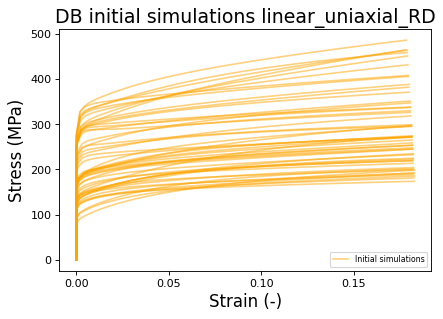

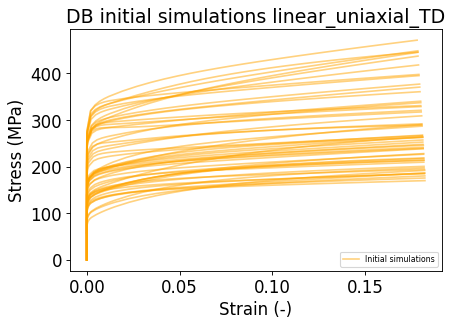

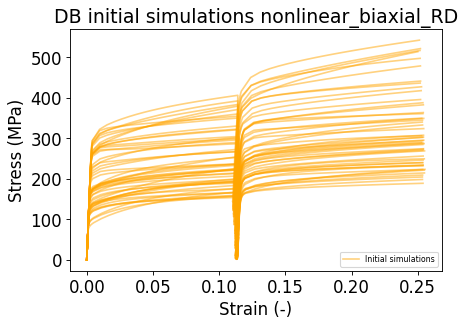

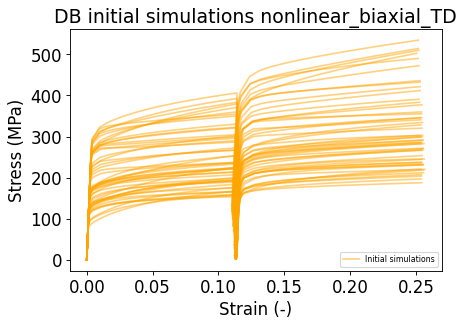

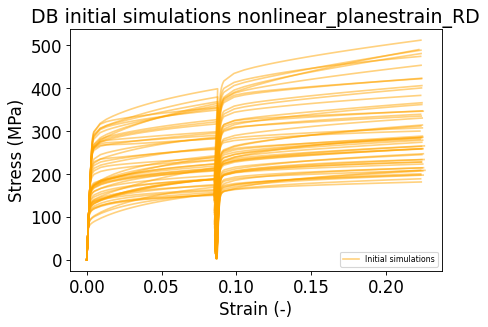

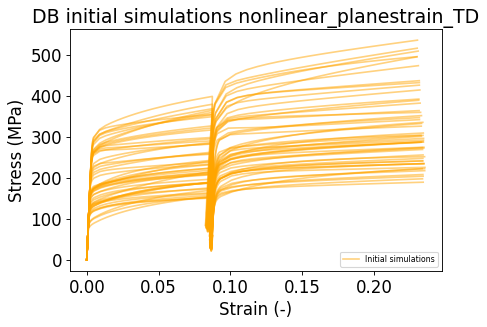

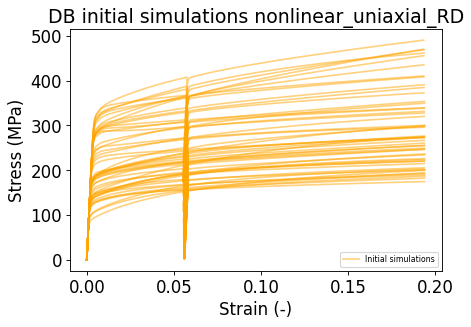

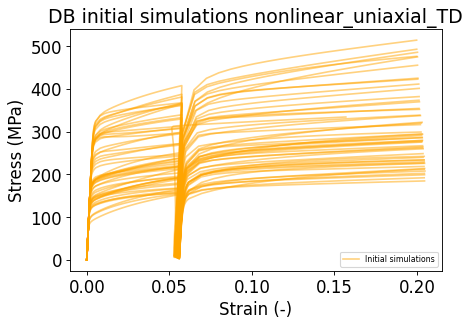

In [3]:
loadings = ["linear_uniaxial_RD", 
            "linear_uniaxial_TD",
            "nonlinear_biaxial_RD", 
            "nonlinear_biaxial_TD",     
            "nonlinear_planestrain_RD",     
            "nonlinear_planestrain_TD",     
            "nonlinear_uniaxial_RD", 
            "nonlinear_uniaxial_TD"]

lower = 0
step = 25
combined_initial_processCurves = {}
combined_initial_trueCurves = {}
combined_initial_params = []
combined_nonconverging_params = []

for loading in loadings:
    combined_initial_processCurves[loading] = {}
    combined_initial_trueCurves[loading] = {}

while lower <= 25:
    for loading in loadings:
        upper = lower + step
        combined_initial_processCurves[loading].update(np.load(f'notebooks/DB2/{lower}-{upper}/{loading}/initial_processCurves.npy', allow_pickle=True).tolist())
        combined_initial_trueCurves[loading].update(np.load(f'notebooks/DB2/{lower}-{upper}/{loading}/initial_trueCurves.npy', allow_pickle=True).tolist())
    initial_params = np.load(f'notebooks/DB2/{lower}-{upper}/common/initial_params.npy', allow_pickle=True).tolist()
    initial_params = [dict(params) for params in initial_params]
    nonconverging_params = np.load(f'notebooks/DB2/{lower}-{upper}/common/nonconverging_params.npy', allow_pickle=True).tolist()
    nonconverging_params = [dict(params) for params in nonconverging_params]

    combined_initial_params += initial_params
    combined_nonconverging_params += nonconverging_params
    lower += step

for loading in loadings:
    np.save(f'notebooks/DB2/combined/{loading}/initial_processCurves.npy', combined_initial_processCurves[loading])
    np.save(f'notebooks/DB2/combined/{loading}/initial_trueCurves.npy', combined_initial_trueCurves[loading])

np.save(f'notebooks/DB2/combined/common/initial_params.npy', combined_initial_params)
np.save(f'notebooks/DB2/combined/common/nonconverging_params.npy', combined_nonconverging_params)


for loading in loadings:
    size = 15
    figure(figsize=(6, 4), dpi=80)

    for curve in combined_initial_processCurves[loading].values():
        processStress = curve["stress"] 
        processStrain = curve["strain"] 
        plt.plot(processStrain, processStress, c='orange', alpha=0.5) 

    plt.plot(processStrain, processStress, label = f"Initial simulations",c='orange', alpha=0.5)
    plt.title(f"DB initial simulations {loading}", size=size + 2)

    plt.rc('xtick', labelsize=size)    
    plt.rc('ytick', labelsize=size)  

    plt.ylabel('Stress (MPa)', size=size)
    plt.xlabel("Strain (-)", size=size)
    plt.legend(loc=4, fontsize=size - 8, ncol=2)

### Combine and plot DB universal initial simulations

True
True
True
True
True
True
(('dipole', 8.89946), ('islip', 294.85293), ('omega', 30.3902), ('p', 0.68184), ('q', 1.69835), ('tausol', 82.29115), ('Qs', 7.96228), ('Qc', 1.98964), ('v0', 21.94897), ('rho_e', 3.84193))
500
500
500
500
500
500
500
500


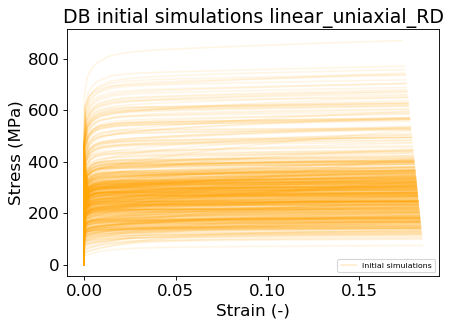

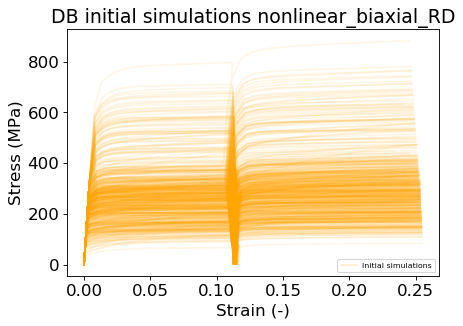

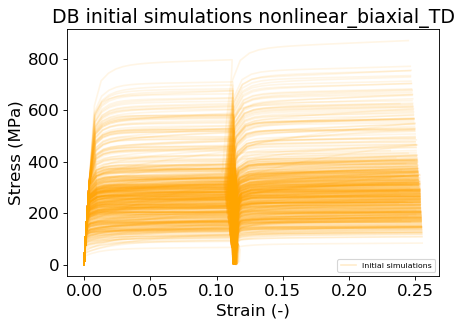

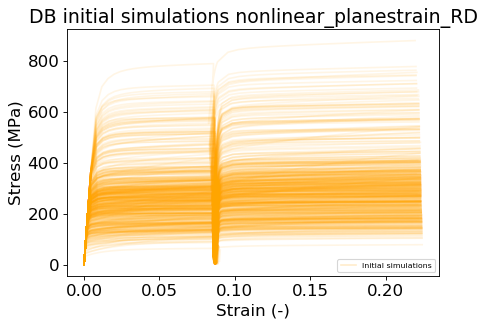

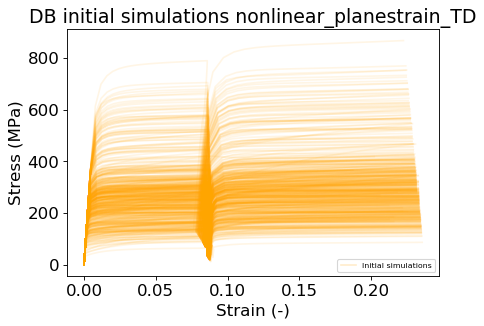

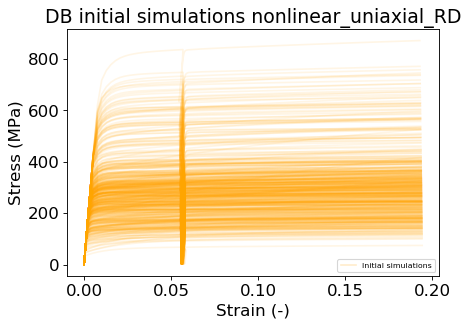

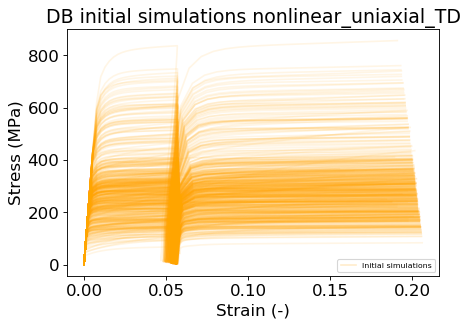

In [6]:
loadings = ["linear_uniaxial_RD", 
            "linear_uniaxial_TD",
            "nonlinear_biaxial_RD", 
            "nonlinear_biaxial_TD",     
            "nonlinear_planestrain_RD",     
            "nonlinear_planestrain_TD",     
            "nonlinear_uniaxial_RD", 
            "nonlinear_uniaxial_TD"]

lower = 0
step = 25
combined_initial_processCurves = {}
combined_initial_trueCurves = {}
combined_initial_params = []
combined_nonconverging_params = []

for loading in loadings:
    combined_initial_processCurves[loading] = {}
    combined_initial_trueCurves[loading] = {}

while lower <= 0:
    upper = lower + step
    #print(f"{lower}-{upper}")
    initial_processCurves = np.load(f'notebooks/DB2/{lower}-{upper}/initial_processCurves.npy', allow_pickle=True)
    initial_processCurves = initial_processCurves.tolist()
    initial_trueCurves = np.load(f'notebooks/DB2/{lower}-{upper}/initial_trueCurves.npy', allow_pickle=True)
    initial_trueCurves = initial_trueCurves.tolist()
    initial_params = np.load(f'notebooks/DB2/{lower}-{upper}/initial_params.npy', allow_pickle=True)
    initial_params = [dict(params) for params in initial_params.tolist()]
    nonconverging_params = np.load(f'notebooks/DB2/{lower}-{upper}/nonconverging_params.npy', allow_pickle=True)
    nonconverging_params = [dict(params) for params in nonconverging_params.tolist()]
    for loading in loadings:
        combined_initial_processCurves[loading].update(initial_processCurves[loading])
        combined_initial_trueCurves[loading].update(initial_trueCurves[loading])
    combined_initial_params += initial_params
    combined_nonconverging_params += nonconverging_params
    lower += step
    #print(combined_initial_params[9])
    #print(combined_initial_params[10])
#print(combined_nonconverging_params)
combined_initial_params = [dict(tupleParams) for tupleParams in list(set([tuple(params.items()) for params in combined_initial_params]))]
combined_nonconverging_params = [dict(tupleParams) for tupleParams in list(set([tuple(params.items()) for params in combined_nonconverging_params]))]

np.save('notebooks/DB/combined/initial_processCurves.npy', combined_initial_processCurves)
np.save('notebooks/DB/combined/initial_trueCurves.npy', combined_initial_trueCurves)
np.save('notebooks/DB/combined/initial_params.npy', combined_initial_params)
np.save('notebooks/DB/combined/nonconverging_params.npy', combined_nonconverging_params)

print(combined_initial_params["nonlinear_planestrain_TD"][27])
def equal(keys1, keys2):
    length = len(keys1)    
    for i in range(0, length):
        if keys1[i] != keys2[i]:
            return False
    return True

print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_biaxial_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_biaxial_TD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_planestrain_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_planestrain_TD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_uniaxial_RD"].keys())))
print(equal(list(combined_initial_processCurves["linear_uniaxial_RD"].keys()), list(combined_initial_processCurves["nonlinear_uniaxial_TD"].keys())))

# for param in combined_initial_processCurves["linear_uniaxial_RD"].keys():
#     print(param)
#     print("\n")

print(list(combined_initial_processCurves["linear_uniaxial_RD"].keys())[199])
### Plotting the curves
initial_data = np.load('notebooks/DB/combined/initial_processCurves.npy', allow_pickle=True)
initial_data = initial_data.tolist()
print(len(initial_data["linear_uniaxial_RD"]))
for loading in loadings:
    size = 15
    figure(figsize=(6, 4), dpi=80)
    count = 0
    for params in initial_data[loading].values():
        if type(params) is dict:
            count += 1
    for curve in initial_data[loading].values():
        processStress = curve["stress"] * 1e-6
        processStrain = curve["strain"] 
        plt.plot(processStrain, processStress, c='orange', alpha=0.1)
    print(count)
    plt.plot(processStrain, processStress, label = f"Initial simulations",c='orange', alpha=0.2)
    plt.title(f"DB initial simulations {loading}", size=size + 2)
    #plt.ylim([0, 330])
    #plt.xlim([0, 0.2])
    plt.rc('xtick', labelsize=size)    
    plt.rc('ytick', labelsize=size)  

    plt.ylabel('Stress (MPa)', size=size)
    plt.xlabel("Strain (-)", size=size)
    plt.legend(loc=4, fontsize=size - 8, ncol=2)

### Generating directories

In [ ]:
start = 0
end = 2000
patchSize = 25
pathPH = f"notebooks/PH"
pathDB = f"notebooks/DB"

for CPLaw in ["PH","DB"]:
    for i in range(start, end, patchSize):
        low = i
        high = i + patchSize
        os.mkdir(f"notebooks/{CPLaw}/{low}-{high}")  
    os.mkdir(f"notebooks/{CPLaw}/combined")

In [ ]:
# param10 = (('a', 6.16409), ('h0', 248.27414), ('tau0', 125.13857), ('tausat', 544.72786), ('self', 0.90446), ('coplanar', 0.63532), ('collinear',  21.96098), ('orthogonal',  0.3852), ('glissile', 0.23713), ('sessile', 1.36269))
# param13 = (('a', 6.51976), ('h0', 1604.6023), ('tau0', 138.57779), ('tausat', 246.37719), ('self', 0.86044), ('coplanar',  1.21061), ('collinear',  2.80141), ('orthogonal',  1.54177), ('glissile', 0.31066), ('sessile', 0.5883))
# param16 = (('a', 5.43022), ('h0', 1863.13157), ('tau0', 191.53827), ('tausat', 781.10955), ('self', 1.91396), ('coplanar', 0.69035), ('collinear', 19.67234), ('orthogonal', 1.25263), ('glissile', 0.56279), ('sessile', 0.05554))
# initial_params = np.load(f'notebooks/PH/0-25/initial_params.npy', allow_pickle=True)
# initial_params = initial_params.tolist()
# initial_params[9] = param10
# initial_params[12] = param13
# initial_params[15] = param16
# np.save(f'notebooks/PH/25-50/initial_params.npy', initial_params)
# initial_params = np.load(f'notebooks/PH/25-50/initial_params.npy', allow_pickle=True)
# initial_params = initial_params.tolist()


# for param in initial_params:
#     print(param)
#     print('\n')

loadings = ["linear_uniaxial_RD", 
            "nonlinear_biaxial_RD", 
            "nonlinear_biaxial_TD",     
            "nonlinear_planestrain_RD",     
            "nonlinear_planestrain_TD",     
            "nonlinear_uniaxial_RD", 
            "nonlinear_uniaxial_TD"]

initial_process = np.load('notebooks/DB/0-25/initial_processCurves.npy', allow_pickle=True)
initial_process = initial_process.tolist()

# initial_true = np.load('notebooks/PH/0-25/initial_trueCurves.npy', allow_pickle=True)
# initial_true = initial_true.tolist()

initial_params = np.load('notebooks/DB/0-25/initial_params.npy', allow_pickle=True)
initial_params = initial_params.tolist()

for param in initial_params:
    print(param)

# for param in initial_process["linear_uniaxial_RD"].keys():
#     print(param)

# indices = [10, 13, 16]

# for loading in loadings:
#     keys = list(initial_process[loading].keys())
#     for index in indices:
#         oldParam = keys[index - 1]
#         newParam = initial_params[index - 1]
#         initial_process[loading][newParam] = initial_process[loading].pop(oldParam)
#         initial_true[loading][newParam] = initial_true[loading].pop(oldParam)

# for param in initial_process["linear_uniaxial_RD"].keys():
#     print(param)
#     print("\n")

# np.save(f'notebooks/PH/25-50/initial_processCurves.npy', initial_process)
# np.save(f'notebooks/PH/25-50/initial_trueCurves.npy', initial_true)

{'dipole': 5.04253, 'islip': 760.12006, 'omega': 6.15309, 'p': 0.41821, 'q': 1.68084, 'tausol': 155.32767, 'Qs': 3.72866, 'Qc': 1.703, 'v0': 38.09405, 'rho_e': 10.10506}
{'dipole': 7.89395, 'islip': 569.71536, 'omega': 1.30066, 'p': 0.52377, 'q': 1.95648, 'tausol': 95.54778, 'Qs': 6.4084, 'Qc': 1.84167, 'v0': 16.84792, 'rho_e': 19.7999}
{'dipole': 8.95949, 'islip': 420.29015, 'omega': 15.3827, 'p': 0.06404, 'q': 1.7944, 'tausol': 401.2006, 'Qs': 7.41331, 'Qc': 1.88009, 'v0': 68.50225, 'rho_e': 8.20411}
{'dipole': 1.50076, 'islip': 339.33067, 'omega': 39.7949, 'p': 0.05804, 'q': 1.26863, 'tausol': 341.42071, 'Qs': 4.97549, 'Qc': 1.78749, 'v0': 98.21711, 'rho_e': 17.26864}
{'dipole': 0.7804, 'islip': 164.91796, 'omega': 48.17409, 'p': 0.3972, 'q': 1.55478, 'tausol': 408.2041, 'Qs': 0.77909, 'Qc': 1.91086, 'v0': 19.86893, 'rho_e': 15.69785}
{'dipole': 1.23062, 'islip': 168.41621, 'omega': 22.23612, 'p': 0.11807, 'q': 1.36468, 'tausol': 361.93097, 'Qs': 2.58419, 'Qc': 1.72461, 'v0': 34.280